This Kernel uses UNet architecture with ResNet34 encoder, I've used [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) library which has many inbuilt segmentation architectures. This kernel is inspired by [Yury](https://www.kaggle.com/deyury)'s discussion thread [here](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/99440#591985). I've used snippets from multiple other public kernels I've given due credits at the end of this notebook.

What's down below?

* UNet with imagenet pretrained ResNet34 architecture
* Training on 512x512 sized images/masks with Standard Augmentations
* MixedLoss (weighted sum of Focal loss and dice loss)
* Gradient Accumulution

In [1]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor
warnings.filterwarnings("ignore")
from pathlib import Path

In [2]:
import segmentation_models_pytorch as smp

## Utility functions

In [3]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [4]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs

Let's use 4 GPUs!


## Dataloader

In [5]:
class SIIMDataset(Dataset):
    def __init__(self, df, data_folder, size, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.gb = self.df.groupby('ImageId')
        self.fnames = list(self.gb.groups.keys())

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        df = self.gb.get_group(image_id)
        annotations = df[' EncodedPixels'].tolist()
        image_path = os.path.join(self.root, image_id + ".png")
        image = cv2.imread(image_path)
        ori_size = image.shape[0]
        mask = np.zeros([ori_size, ori_size])
        if annotations[0] != ' -1':
            for rle in annotations:
                mask += run_length_decode(rle,height=ori_size, width=ori_size)
        mask = (mask >= 1).astype('float32') # for overlap cases
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.fnames)

mean = (0.485, 0.456, 0.406),
std = (0.229, 0.224, 0.225),    
class SIIMDataset2(Dataset):
    def __init__(self, df, data_folder, size, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)

    def __getitem__(self, idx):
        row = self.df.iloc[idx] 
        image_id = row['ImageId']
        annotations = [row['EncodedPixels']]
        image_path = str(row['path'])
        
        try:
            image = cv2.imread(image_path)
        except:
            raise ValueError(f'file not found: {image_path}')
        ori_size = image.shape[0]
        mask = np.zeros([ori_size, ori_size])
        if annotations[0].strip() != '-1':
            for rle in annotations:
                mask += run_length_decode(rle,height=ori_size, width=ori_size)
        mask = (mask >= 1).astype('float32') # for overlap cases
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.df)


from albumentations import (RandomGamma, MotionBlur, RandomBrightnessContrast, 
                            GridDistortion, CLAHE, OneOf, Blur)

def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                # HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=5, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
                RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                # RandomGamma(gamma_limit=(80, 120),p=0.2),
                # Blur(blur_limit=5, p=0.2),
                # ISONoise(color_shift=(0.01,0.01), intensity=(0.1,0.1), p=0.2),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            # CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=1.0),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    fold,
    total_folds,
    data_folder,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
    sample=None,
):
    df = pd.read_csv(df_path)
    df = df.drop_duplicates('ImageId')
    df_with_mask = df[df[" EncodedPixels"] != " -1"]
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df[" EncodedPixels"] == " -1"]
    df_without_mask['has_mask'] = 0
    df_without_mask_sampled = df_without_mask.sample(len(df_with_mask.drop_duplicates('ImageId')))
    df = pd.concat([df_with_mask, df_without_mask_sampled])
    #NOTE: equal number of positive and negative cases are chosen.
    
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
    train_idx, val_idx = list(kfold.split(
        df["ImageId"], df["has_mask"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
    
    if sample is not None:
        df = df.head(sample)
    image_dataset = SIIMDataset(df, data_folder, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

def provider2(
    fold,
    total_folds,
    df_path,
    phase,
    size,
    lookup_dict,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
    seed=42,
    down_sample = False,
    sample=None
):
    print('phase: ', phase)
    df = prepare_df(df_path, lookup_dict, down_sample, seed)    
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=seed)
    train_idx, val_idx = list(kfold.split(
        df["ImageId"], df["has_mask"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
    if sample is not None:
        df = df.head(sample)
    print(f'*****  phase {phase} data set rows: {len(df)}')
    if ((not down_sample) and (phase == 'train')):
        df_without_mask = df[df['has_mask'] == 0]
        df_with_mask = df[df['has_mask'] == 1]
        df_with_mask_sampled = df_with_mask.loc[
            resample(df_with_mask.index, n_samples=len(df_without_mask), replace=True, random_state=seed)]
        df = pd.concat([df_with_mask_sampled, df_without_mask]).sample(frac=1.0, random_state=seed)
        print(f'train original rows: {len(df_with_mask) + len(df_without_mask)} to rows: {len(df)}')
        
    image_dataset = SIIMDataset2(df, data_folder, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

from sklearn.utils import resample

def find_files(data_folder, look_phrase = '**/*.png'):
    allfiles = list(Path(data_folder).glob(look_phrase))
    lookup_dict = {}
    for x in allfiles:
        indx = str(x).split('/')[-1].split('.png')[0]
        lookup_dict[indx] = x
    return lookup_dict

def prepare_df(df_path, lookup_dict, down_sample = True, seed=42):
    df = pd.read_csv(df_path)
    print(f'original rows: {len(df)}')
    # df = df.drop_duplicates('ImageId')
    # print(f'rows after drop_duplicate: {len(df)}')

    df['path'] = [lookup_dict[x] for x in df['ImageId']]
    df_with_mask = df[df["EncodedPixels"] != "-1"]
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df["EncodedPixels"] == "-1"]
    df_without_mask['has_mask'] = 0
    print(f'rows with mask: {len(df_with_mask)}, without mask: {len(df_without_mask)}')
    if not down_sample:
        # df_with_mask_sampled = df_with_mask.loc[
        #     resample(df_with_mask.index, n_samples=len(df_without_mask), replace=True, random_state=seed)]
        df = pd.concat([df_with_mask, df_without_mask])
    else:
        df_without_mask_sampled = df_without_mask.loc[
            resample(df_without_mask.index, n_samples=len(df_with_mask.drop_duplicates()), replace=True, random_state=seed)]
        df = pd.concat([df_with_mask, df_without_mask_sampled])
    print(f'sampled data to rows: {len(df)}')
    #NOTE: equal number of positive and negative cases are chosen.
    return df.sample(frac=1.0, random_state=seed)

In [6]:
%cd ~/Workspace/kaggle-2019Q3-siim/

/home/chengjiun/Workspace/kaggle-2019Q3-siim


In [7]:
sample_submission_path = './input/stage_2_sample_submission.csv'
train_rle_path = './input/stage_2_train.csv'
data_folder = "./input/stage1_png/"
test_data_folder = "./input/stage2_png/"

### Dataloader sanity check

In [8]:
lookup_dict = find_files(data_folder, look_phrase = '**/*.png')

In [9]:
dataloader = provider2(
    fold=0,
    total_folds=5,
    df_path=train_rle_path,
    phase="train",
    size=512,
    lookup_dict=lookup_dict,
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    batch_size=4,
    num_workers=1,
    seed=42,
    down_sample = False
)

phase:  train
original rows: 12954
rows with mask: 3576, without mask: 9378
sampled data to rows: 12954
*****  phase train data set rows: 10362
train original rows: 10362 to rows: 15004


In [46]:
batch = next(iter(dataloader)) # get a batch from the dataloader
images, masks = batch


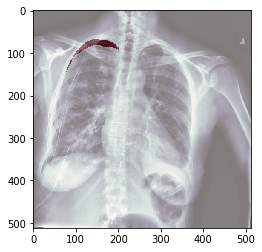

In [47]:
# plot some random images in the `batch`
idx = random.choice(range(4))
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.5, cmap='Reds')
plt.show()
if len(np.unique(masks[idx][0])) == 1: # only zeros
    print('Chosen image has no ground truth mask, rerun the cell')

## Losses

This kernel uses a weighted sum of Focal Loss and Dice Loss, let's call it MixedLoss

In [9]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

## Some more utility functions

Here are some utility functions for calculating IoU and Dice scores

In [10]:
def predict_func(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict_func(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## UNet with ResNet34 model
Let's take a look at the model

In [11]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)

Let's use 4 GPUs!


In [12]:
from ranger import Ranger
from fastai.core import *
opt_ranger = partial(Ranger, k=8)


In [32]:
model

DataParallel(
  (module): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

## Model Training and validation

In [15]:
class ModelCompiler(object):
    def __init__(self, model):
        self.device = torch.device('cuda:0')
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.criterion = MixedLoss(10.0, 2.0)


    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

from ranger import Ranger
optar = partial(Ranger, k=8)
    
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model_compiler, num_workers = 16, batch_size=(32,16), lr = 5e-4, 
                 n_epochs=100, fold=1, total_folds=5, size=512, down_sample=False,
                 Optim_factor=0.1, Optim_patience=3, Optim_cooldown=0, sample=None, seed=42):
        self.fold = fold
        self.total_folds = 5
        self.num_workers = num_workers
        self.batch_size = {"train": batch_size[0], "val": batch_size[1]}
        self.accumulation_steps = max([2, 16 // self.batch_size['train']])
        self.lr = lr
        self.num_epochs = n_epochs
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.model_compiler = model_compiler
        # self.optimizer = optim.Adam(self.model_compiler.net.parameters(), lr=self.lr)
        self.optimizer = opt_ranger(self.model_compiler.net.parameters(), lr=self.lr)

        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", 
                                           factor=Optim_factor, cooldown=Optim_cooldown, patience=Optim_patience,
                                           verbose=True)

        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider2(
                fold=fold,
                total_folds=total_folds,
                df_path=train_rle_path,
                phase=phase,
                size=size,
                lookup_dict=lookup_dict,                
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
                seed=seed,
                down_sample = down_sample,
                sample=sample
            )
            for phase in self.phases}

        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.model_compiler.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            if phase == 'train':
                self.model_compiler.net.train()
            else:
                self.model_compiler.net.eval()
            images, targets = batch
            loss, outputs = self.model_compiler.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self, model_path = './model_pytorch__unet_resnet34.pth'):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.model_compiler.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, model_path)
            print()

In [16]:
num_workers = 8
# batch_size=(12,8) # size 1024
# batch_size=(32,16) # size 512
# batch_size=(16,12) # size 512 single GPU
batch_size=(72,48) # size 512 single GPU
lr = 1e-3
n_epochs=24
total_folds=5
fold = 0
Optim_factor = 0.1
Optim_patience = 3
Optim_cooldown = 1

model_compiler = ModelCompiler(model)

model_trainer = Trainer(model_compiler, num_workers = num_workers, 
                        batch_size=batch_size, lr = lr, n_epochs=n_epochs, seed=50,
                        total_folds=total_folds, fold=fold, size=512, sample=None,
                        Optim_factor=Optim_factor, Optim_patience=Optim_patience, Optim_cooldown=Optim_cooldown)

model_path = f'./stage2_model2_pytorch_unet_resnet34_CV{fold}-CLAHE-512.pth'


phase:  train
original rows: 12954
rows with mask: 3576, without mask: 9378
sampled data to rows: 12954
*****  phase train data set rows: 10362
train original rows: 10362 to rows: 15004
phase:  val
original rows: 12954
rows with mask: 3576, without mask: 9378
sampled data to rows: 12954
*****  phase val data set rows: 2592


In [ ]:
model_trainer.start(model_path)

Starting epoch: 0 | phase: train | ⏰: 08:40:04
Loss: 2.2659 | dice: 0.2027 | dice_neg: 0.0800 | dice_pos: 0.3251 | IoU: 0.2256
Starting epoch: 0 | phase: val | ⏰: 08:45:27
Loss: 2.5420 | dice: 0.2790 | dice_neg: 0.2771 | dice_pos: 0.2797 | IoU: 0.1987
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 08:46:19
Loss: 1.5495 | dice: 0.4329 | dice_neg: 0.4781 | dice_pos: 0.3905 | IoU: 0.2865
Starting epoch: 1 | phase: val | ⏰: 08:51:41
Loss: 2.2425 | dice: 0.5968 | dice_neg: 0.7301 | dice_pos: 0.2466 | IoU: 0.1816
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 08:52:33
Loss: 1.2547 | dice: 0.5533 | dice_neg: 0.6771 | dice_pos: 0.4315 | IoU: 0.3275
Starting epoch: 2 | phase: val | ⏰: 08:57:56
Loss: 2.0401 | dice: 0.6342 | dice_neg: 0.7712 | dice_pos: 0.2710 | IoU: 0.2015
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 08:58:47
Loss: 1.1127 | dice: 0.5978 | dice_neg: 0.73

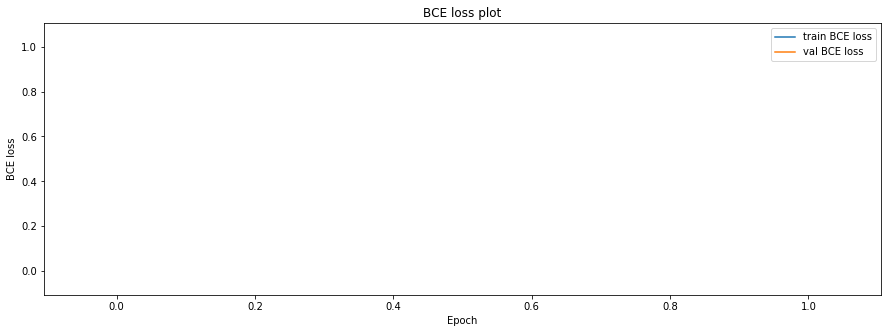

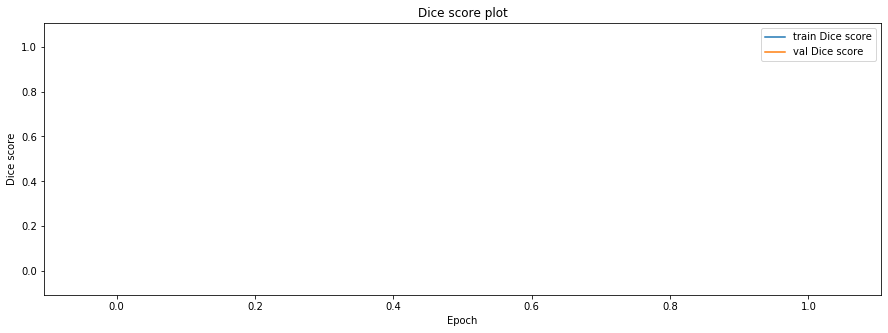

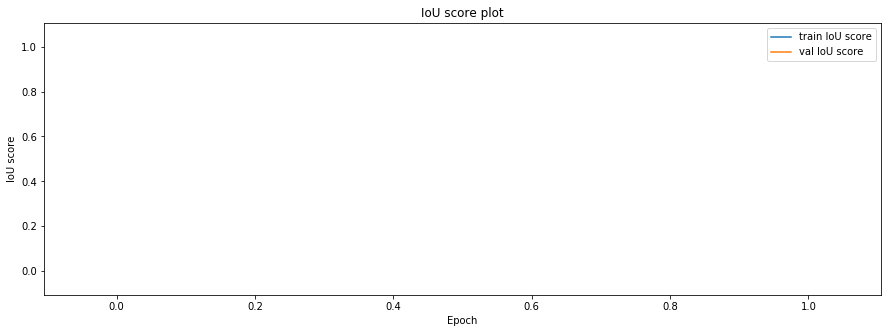

In [19]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

## Test prediction

In [13]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".png")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return images

    def __len__(self):
        return self.num_samples

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

# single fold

In [15]:
%cd ~/Workspace/kaggle-2019Q3-siim/

/home/chengjiun/Workspace/kaggle-2019Q3-siim


In [18]:
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 32
best_threshold = 0.5
min_size = 3500
device = torch.device("cuda:0")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

# model = smp.Unet("se_resnext50_32x4d", encoder_weights="imagenet", activation=None)
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = nn.DataParallel(model)
model = model_trainer.model_compiler.net        
model.eval()


fold = 0
total_folds = 5
model_path = f'./stage2_model2_pytorch_unet_resnet34_CV{fold}-CLAHE-512.pth'
state = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv(f'submission-stage2-2-unet-resnet34_cv{fold}in{total_folds}-CLAHE-512.csv', columns=['ImageId', 'EncodedPixels'], index=False)




In [59]:
del model_compiler, model, model_trainer
torch.cuda.empty_cache()

In [17]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)
    
num_workers = 8
# batch_size=(12,8) # size 1024
# batch_size=(32,16) # size 512
# batch_size=(16,12) # size 512 single GPU
batch_size=(80,54) # size 512 4 GPU
# batch_size=(128,54) # size 512 6 GPU
lr = 5e-3
n_epochs=16
total_folds=5
fold = 3
Optim_factor = 0.1
Optim_patience = 2
Optim_cooldown = 1

model_compiler = ModelCompiler(model)

model_trainer = Trainer(model_compiler, num_workers = num_workers, 
                        batch_size=batch_size, lr = lr, n_epochs=n_epochs, seed=5044+fold,
                        total_folds=total_folds, fold=fold, size=512, sample=None, down_sample=True,
                        Optim_factor=Optim_factor, Optim_patience=Optim_patience, Optim_cooldown=Optim_cooldown)

model_path = f'./stage2_model3_pytorch_unet_resnet34_CV{fold}-CLAHE-512.pth'



Let's use 4 GPUs!
phase:  train
original rows: 12954
rows with mask: 3576, without mask: 9378
sampled data to rows: 7152
*****  phase train data set rows: 5722
phase:  val
original rows: 12954
rows with mask: 3576, without mask: 9378
sampled data to rows: 7152
*****  phase val data set rows: 1430


In [18]:
model_trainer.start(model_path)

Starting epoch: 0 | phase: train | ⏰: 11:53:49
Loss: 5.1696 | dice: 0.0282 | dice_neg: 0.0000 | dice_pos: 0.0575 | IoU: 0.0349
Starting epoch: 0 | phase: val | ⏰: 11:56:23
Loss: 3.8333 | dice: 0.1011 | dice_neg: 0.0000 | dice_pos: 0.2032 | IoU: 0.1262
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 11:56:57
Loss: 2.6353 | dice: 0.1677 | dice_neg: 0.0663 | dice_pos: 0.2680 | IoU: 0.1774
Starting epoch: 1 | phase: val | ⏰: 11:59:17
Loss: 2.3746 | dice: 0.2605 | dice_neg: 0.2382 | dice_pos: 0.2817 | IoU: 0.1938
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 11:59:52
Loss: 1.8019 | dice: 0.3394 | dice_neg: 0.3621 | dice_pos: 0.3198 | IoU: 0.2267
Starting epoch: 2 | phase: val | ⏰: 12:02:04
Loss: 6.9533 | dice: 0.1181 | dice_neg: 0.0305 | dice_pos: 0.2053 | IoU: 0.1294

Starting epoch: 3 | phase: train | ⏰: 12:02:34
Loss: 1.5723 | dice: 0.3914 | dice_neg: 0.4641 | dice_pos: 0.3210 | IoU: 0.2292
Starting epoch

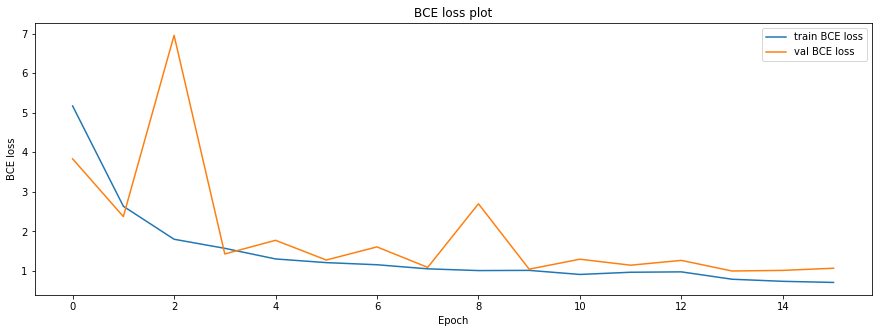

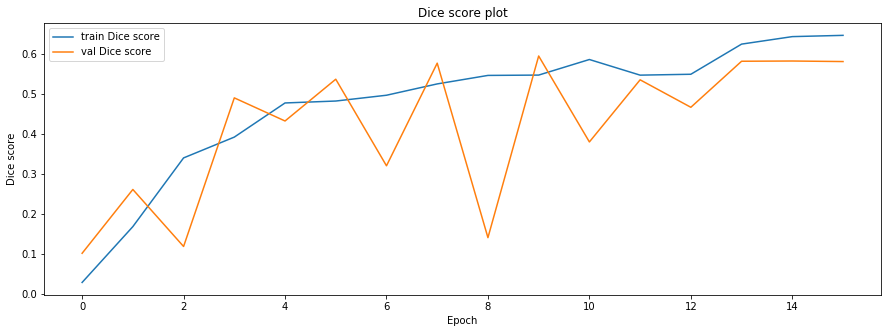

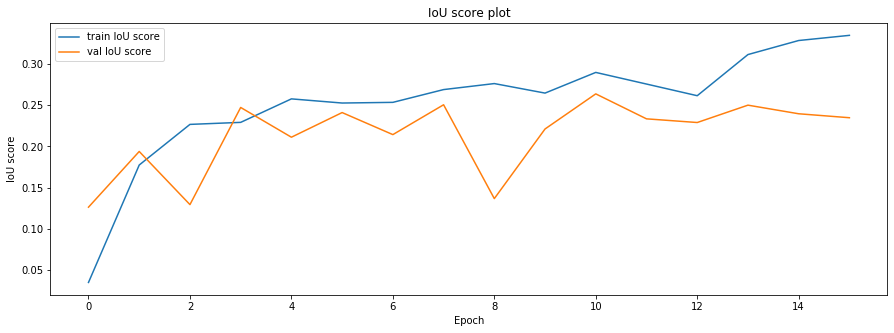

In [20]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

In [19]:
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 64
best_threshold = 0.5
min_size = 3500
device = torch.device("cuda:0")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)

# model = smp.Unet("se_resnext50_32x4d", encoder_weights="imagenet", activation=None)
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = nn.DataParallel(model)
model = model_trainer.model_compiler.net        
model.eval()

model_path = f'./stage2_model3_pytorch_unet_resnet34_CV{fold}-CLAHE-512.pth'
state = torch.load(model_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv(f'submission-stage2-3-unet-resnet34_cv{fold}in{total_folds}-CLAHE-512.csv', columns=['ImageId', 'EncodedPixels'], index=False)

In [18]:
model_path

'./model_pytorch__unet_resnet34_CV0-CLAHE-512.pth'

In [17]:
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6567.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6170.151787519...,364717 3 1020 4 1018 6 1016 7 1015 10 1012 12 ...
2,1.2.276.0.7230010.3.1.4.8323329.6346.151787519...,183552 2 1015 10 1012 12 1010 14 1009 14 1007 ...
3,1.2.276.0.7230010.3.1.4.8323329.6890.151787520...,272653 4 1018 6 1015 9 1013 10 1012 12 1010 13...
4,1.2.276.0.7230010.3.1.4.8323329.6400.151787519...,549118 5 1014 15 1006 20 1001 25 997 30 992 34...


In [25]:
type(probability), probability.shape, type(predict), len(predict)

(numpy.ndarray, (1024, 1024), numpy.ndarray, 1024)

# ensemble 3

In [14]:
# del model, model_trainer, 
del model_compiler
torch.cuda.empty_cache()

NameError: name 'model_compiler' is not defined

In [17]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)

Let's use 4 GPUs!


In [18]:
num_workers = 8
batch_size=(80,54) # size 512 4 GPU
lr = 1e-3
n_epochs=12
total_folds=3
size = 512
Optim_factor = 0.1
Optim_patience = 4
Optim_cooldown = 0
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

test_batch_size=48

losses = []
dice_scores = []
iou_scores = []
model_trainer = None

In [21]:

for i in range(3):
    fold = i
    del model, model_trainer
    torch.cuda.empty_cache()
    
    model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model)
    model_compiler = ModelCompiler(model)

    down_sample=True
    model_trainer = Trainer(model_compiler, num_workers = num_workers, 
                        batch_size=batch_size, lr = lr, n_epochs=n_epochs, seed = 54221 + i,
                        total_folds=total_folds, fold=fold, size=size, sample=None, down_sample=down_sample,
                        Optim_factor=Optim_factor, Optim_patience=Optim_patience, Optim_cooldown=Optim_cooldown)
    
    model_path = f'./stage2_model2_pytorch_unet_resnet34_CV{fold}in{total_folds}-CLAHE.pth'
    print(f'train on {fold}')

    model_trainer.start(model_path)

    losses.append(model_trainer.losses)
    dice_scores.append(model_trainer.dice_scores) # overall dice
    iou_scores.append(model_trainer.iou_scores)
    
    
    # write to submit
    print(f'run test {fold}')
    best_threshold = 0.5
    min_size = 3500
    device = torch.device("cuda:0")
    te_df = pd.read_csv(sample_submission_path)
    testset = DataLoader(
        TestDataset(test_data_folder, te_df, size, mean, std),
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    interpretor = model_trainer.model_compiler.net        
    interpretor.eval()
    state = torch.load(model_path, map_location=lambda storage, loc: storage)
    interpretor.load_state_dict(state["state_dict"])


    encoded_pixels = []
    for i, batch in enumerate(tqdm(testset)):
        preds = torch.sigmoid(interpretor(batch.to(device)))
        preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
        for probability in preds:
            if probability.shape != (1024, 1024):
                probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
            predict, num_predict = post_process(probability, best_threshold, min_size)
            if num_predict == 0:
                encoded_pixels.append('-1')
            else:
                r = run_length_encode(predict)
                encoded_pixels.append(r)
    te_df['EncodedPixels'] = encoded_pixels
    te_df.to_csv(f'submission-stage2-5-unet-resnet34_cv{fold}in{total_folds}-CLAHE-512.csv', columns=['ImageId', 'EncodedPixels'], index=False)

Let's use 4 GPUs!
phase:  train
original rows: 12954
rows with mask: 3576, without mask: 9378
sampled data to rows: 7152
*****  phase train data set rows: 4768
phase:  val
original rows: 12954
rows with mask: 3576, without mask: 9378
sampled data to rows: 7152
*****  phase val data set rows: 2384
train on 0
Starting epoch: 0 | phase: train | ⏰: 16:58:54
Loss: 4.4856 | dice: 0.0277 | dice_neg: 0.0000 | dice_pos: 0.0549 | IoU: 0.0298
Starting epoch: 0 | phase: val | ⏰: 17:00:50
Loss: 3.2766 | dice: 0.0648 | dice_neg: 0.0000 | dice_pos: 0.1323 | IoU: 0.0782
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 17:01:31
Loss: 2.6589 | dice: 0.0907 | dice_neg: 0.0004 | dice_pos: 0.1812 | IoU: 0.1144
Starting epoch: 1 | phase: val | ⏰: 17:03:01
Loss: 2.2373 | dice: 0.1187 | dice_neg: 0.0000 | dice_pos: 0.2392 | IoU: 0.1566
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 17:03:41
Loss: 1.6579 | dice: 0.2324 | dice_neg

KeyboardInterrupt: 

In [22]:
def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

In [ ]:
cv = 0
plot(losses[cv], f"CV-{cv} BCE loss")
plot(dice_scores[cv], f"CV-{cv} Dice score")
plot(iou_scores[cv], f"CV-{cv} IoU score")


In [ ]:
cv = 1
plot(losses[cv], f"CV-{cv} BCE loss")
plot(dice_scores[cv], f"CV-{cv} Dice score")
plot(iou_scores[cv], f"CV-{cv} IoU score")


In [23]:
cv = 2
plot(losses[cv], f"CV-{cv} BCE loss")
plot(dice_scores[cv], f"CV-{cv} Dice score")
plot(iou_scores[cv], f"CV-{cv} IoU score")


IndexError: list index out of range

# ensemble


In [43]:
# read all submissions into daframes and store them in a list
from glob import glob
# files = glob('./submission-stage2-*')
files = ['submission-stage2-2-unet-resnet34_cv0in5-CLAHE-512.csv', 'submission-stage2-3-unet-resnet34_cv2in5-CLAHE-512.csv']
df_sub_list = [pd.read_csv(f) for f in files]
print(len(df_sub_list))

2


In [44]:
# create a list of unique image IDs
iid_list = df_sub_list[0]["ImageId"].unique()
print(f"{len(iid_list)} unique image IDs.")

3205 unique image IDs.


In [45]:
# set here the threshold for the final mask
# min_solutions is the minimum number of times that a pixel has to be positive in order to be included in the final mask
min_solutions = 2 # a number between 1 and the number of submission files
assert (min_solutions >= 1 and min_solutions <= len(df_sub_list)), \
    "min_solutions has to be a number between 1 and the number of submission files"

In [46]:
# create empty final dataframe
df_avg_sub = pd.DataFrame(columns=["ImageId", "EncodedPixels"])
df_avg_sub_idx = 0 # counter for the index of the final dataframe
from input.mask_functions import *
import skimage
# iterate over image IDs
for iid in tqdm(iid_list):
    # initialize prediction mask
    avg_mask = np.zeros((1024,1024))
    # iterate over prediction dataframes
    for df_sub in df_sub_list:
        # extract rles for each image ID and submission dataframe
        rles = df_sub.loc[df_sub["ImageId"]==iid, "EncodedPixels"]
        # iterate over rles
        for rle in rles:
            # if rle is not -1, build prediction mask and add to average mask
            if "-1" not in str(rle):
                avg_mask += rle2mask(rle, 1024, 1024) / float(len(df_sub_list))
    # threshold the average mask
    avg_mask = (avg_mask >= (min_solutions * 255. / float(len(df_sub_list)))).astype("uint8")
    # extract rles from the average mask
    avg_rle_list = []
    if avg_mask.max() > 0:
        # label regions
        labeled_avg_mask, n_labels = skimage.measure.label(avg_mask, return_num=True)
        # iterate over regions, extract rle, and save to a list
        for label in range(1, n_labels+1):
            avg_rle = mask2rle((255 * (labeled_avg_mask == label)).astype("uint8"), 1024, 1024)
            avg_rle_list.append(avg_rle)
    else:
        avg_rle_list.append("-1")
    # iterate over average rles and create a row in the final dataframe
    for avg_rle in avg_rle_list:
        df_avg_sub.loc[df_avg_sub_idx] = [iid, avg_rle]
        df_avg_sub_idx += 1 # increment index

In [34]:
df_avg_sub.shape


(3286, 2)

In [35]:
df_avg_sub["ImageId"].nunique()

3205

In [36]:
df_avg_sub.head()

,ImageId,EncodedPixels
0,ID_0011fe81e,-1
1,ID_9ca06e9b9,-1
2,ID_6f00d6ce6,-1
3,ID_9258110b0,-1
4,ID_fa01c9546,323844 2 1 4 1015 11 1010 14 1008 18 1004 22 1...


In [47]:
df_avg_sub.to_csv(f'submission-ensemble2-all.csv', columns=['ImageId', 'EncodedPixels'], index=False)

In [48]:
(df_avg_sub['EncodedPixels'] != '-1').mean()

0.09904054472299598

In [27]:
(df_avg_sub['EncodedPixels'] != '-1').mean()

0.08471965495995071

In [29]:
df = pd.read_csv('submission-stage2-2-unet-resnet34_cv0in5-CLAHE-512.csv')
(df['EncodedPixels'] != '-1').mean()

0.12480499219968799

In [34]:
df = pd.read_csv('submission-stage2-4-unet-resnet34_cv1in3-CLAHE-512.csv')
(df['EncodedPixels'] != '-1').mean()

0.27769110764430577

In [36]:
df = pd.read_csv('submission-stage2-3-unet-resnet34_cv2in5-CLAHE-512.csv')
(df['EncodedPixels'] != '-1').mean()

0.14258970358814352